In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "autsimData/consolidated",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2926 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['autistic', 'non_autistic']


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1]


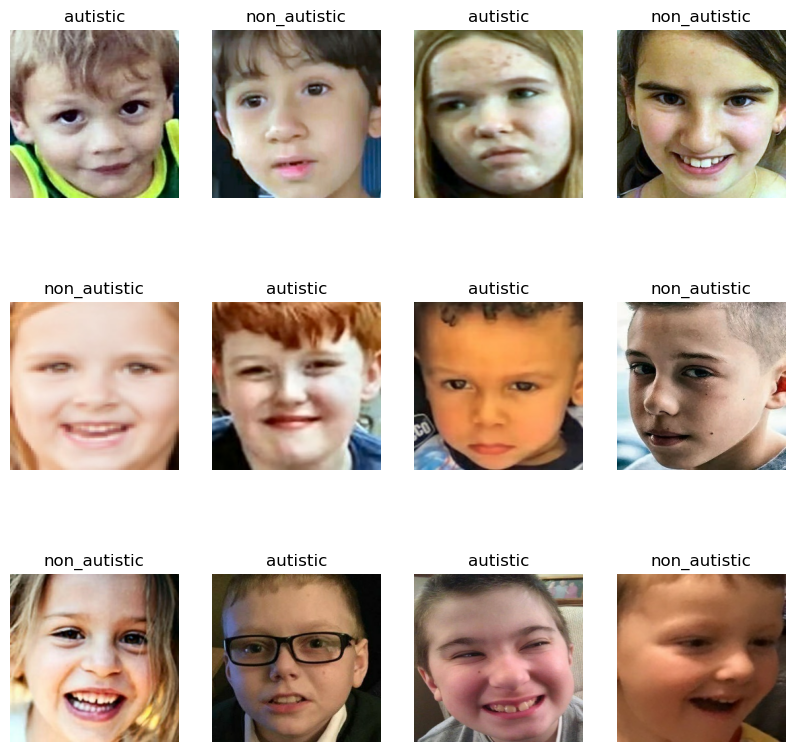

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

92

In [19]:
#if we are taking 0.8 as train then:
train_size = 0.8
len(dataset)*train_size

73.60000000000001

In [20]:
train_ds = dataset.take(73)
len(train_ds)

73

In [21]:
test_ds = dataset.skip(73)
len(test_ds)

19

In [22]:
val_size=0.1
len(dataset)*val_size

9.200000000000001

In [23]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [24]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [25]:
#randomize
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

73
9
10


In [29]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Building

In [30]:
#Normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256)
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
#apply data augmention to train set
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
#Model Building 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [35]:
#We used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
73/73 [==============================] - 324s 4s/step - loss: 0.7313 - accuracy: 0.4931 - val_loss: 0.6949 - val_accuracy: 0.4931
Epoch 2/10
73/73 [==============================] - 254s 3s/step - loss: 0.6995 - accuracy: 0.5073 - val_loss: 0.7173 - val_accuracy: 0.4757
Epoch 3/10
73/73 [==============================] - 254s 3s/step - loss: 0.6986 - accuracy: 0.4970 - val_loss: 0.6751 - val_accuracy: 0.5278
Epoch 4/10
73/73 [==============================] - 248s 3s/step - loss: 0.6620 - accuracy: 0.6005 - val_loss: 0.5746 - val_accuracy: 0.7118
Epoch 5/10
73/73 [==============================] - 257s 4s/step - loss: 0.6251 - accuracy: 0.6592 - val_loss: 0.5628 - val_accuracy: 0.7014
Epoch 6/10
73/73 [==============================] - 249s 3s/step - loss: 0.6029 - accuracy: 0.6764 - val_loss: 0.5840 - val_accuracy: 0.6979
Epoch 7/10
73/73 [==============================] - 274s 4s/step - loss: 0.5967 - accuracy: 0.6812 - val_loss: 0.5840 - val_accuracy: 0.7083
Epoch 8/10
73

In [37]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 21s 955ms/step - loss: 0.5889 - accuracy: 0.7219


In [38]:
scores

[0.5889452695846558, 0.721875011920929]

In [39]:
#Plotting accuracy and loss curves
history

In [40]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 73}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

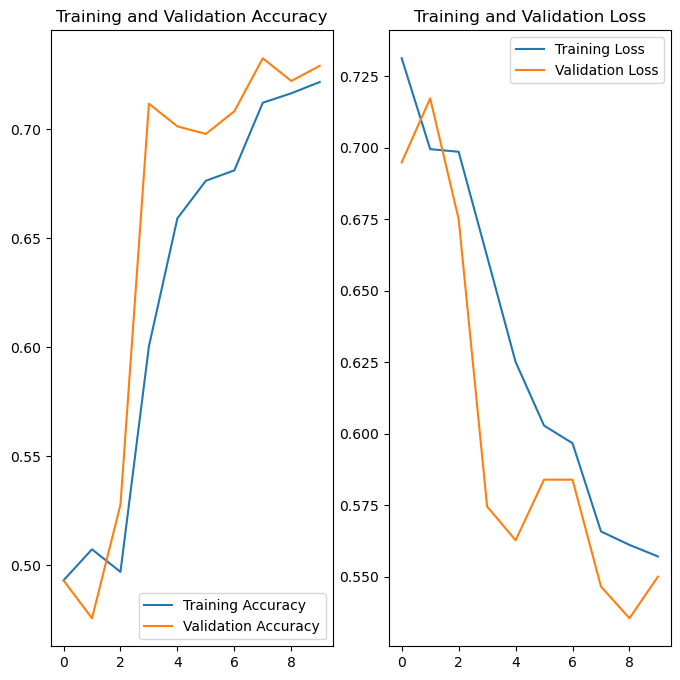

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: autistic
1/1 [==============================] - 1s 1s/step
predicted label: autistic


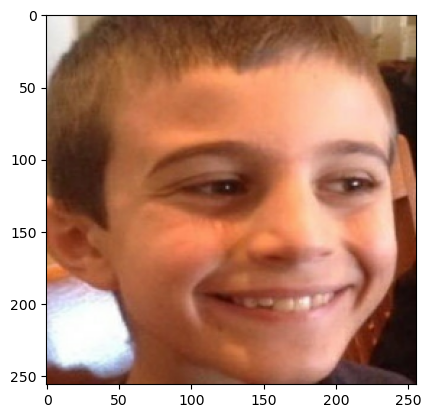

In [44]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
#Inference testing
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


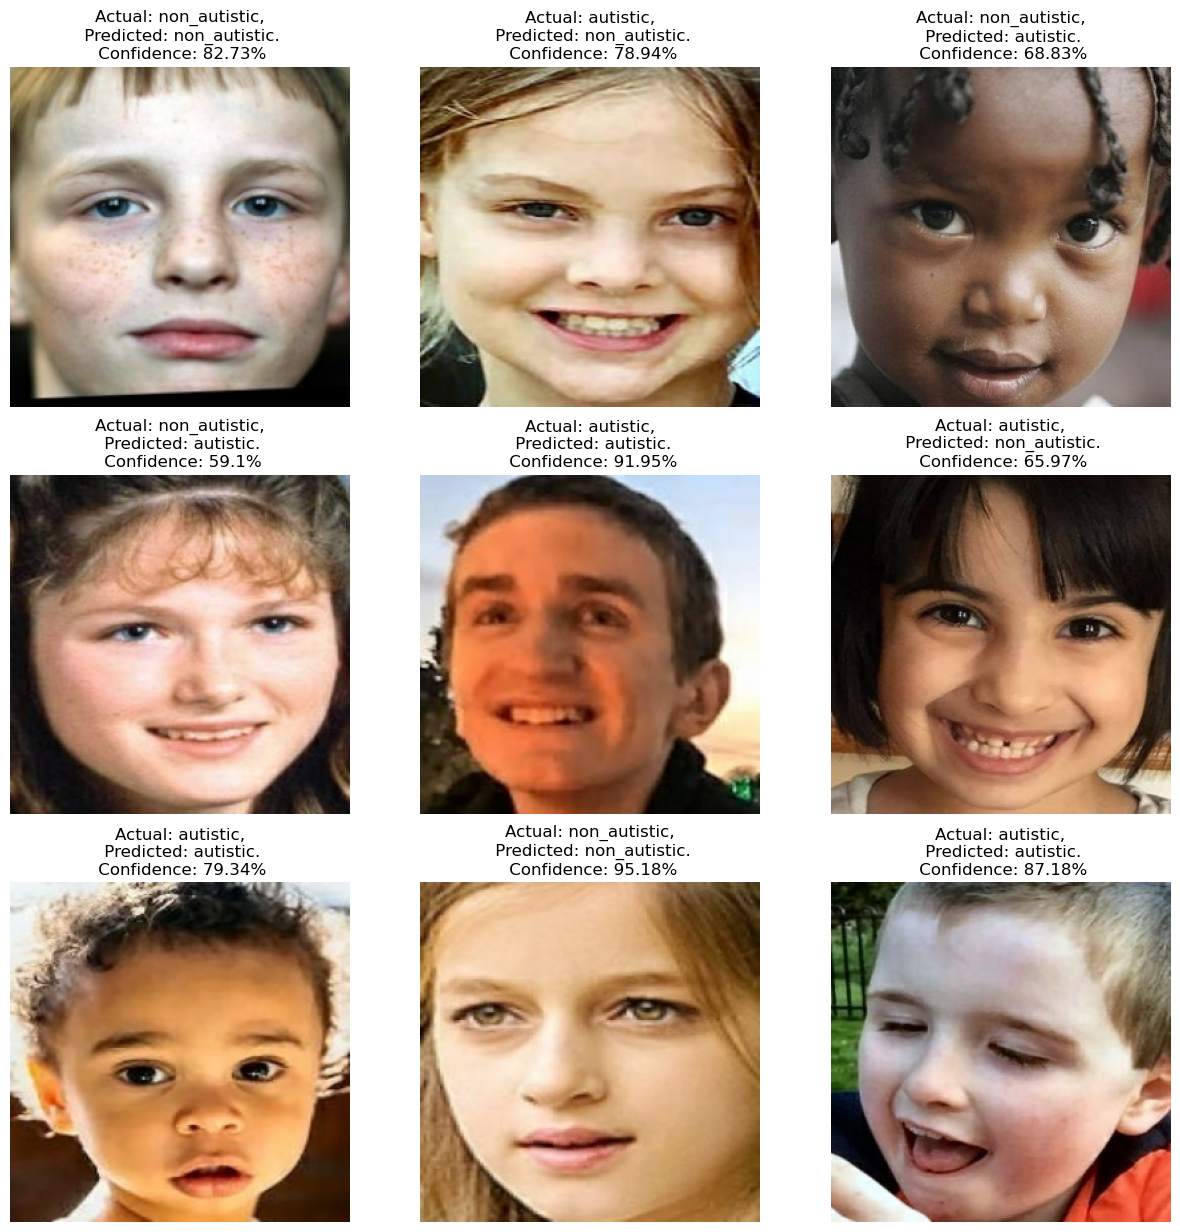

In [46]:
#running inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
#Saving the model
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"../models/{model_version}")

ValueError: invalid literal for int() with base 10: 'Autsim.h5'

In [54]:
model.save("models/Autsim.h5")